1

2


--- Ejecutando método: NORMAL ---
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=42, Mon Jun  9 12:57:49 2025)

--- Ejecutando método: SOBOL ---
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 10 (seed=42, Mon Jun  9 12:57:49 2025)

--- Ejecutando método: HALTON ---
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=42, Mon Jun  9 12:57:50 2025)


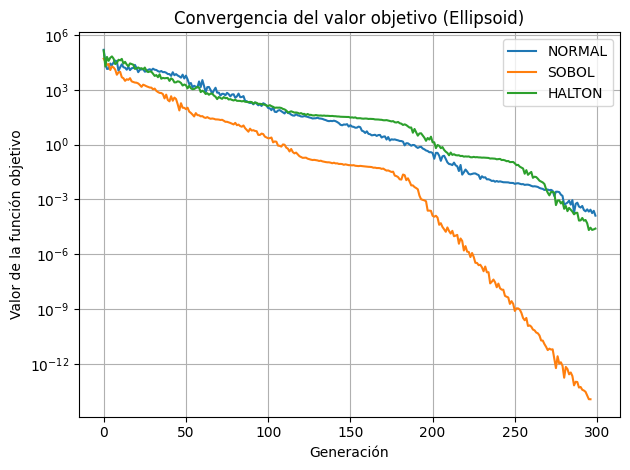

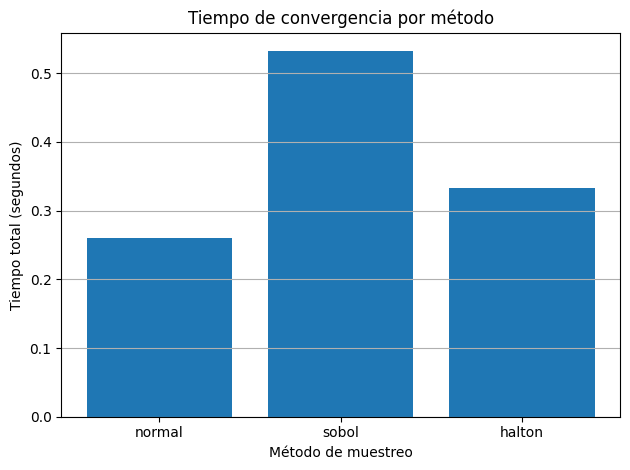

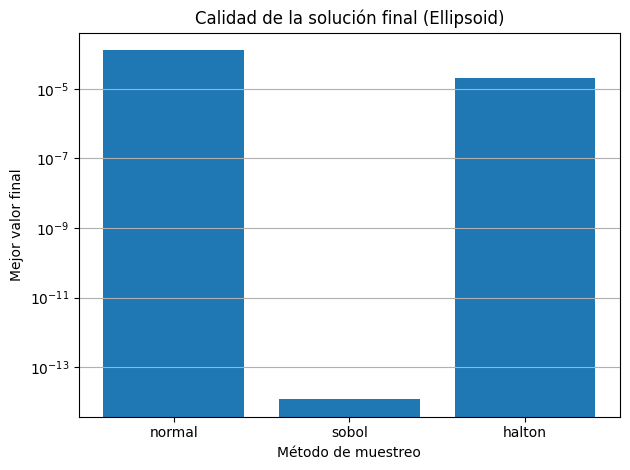

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc, norm
import cma
import time

# ----------------------
# Función objetivo: Ellipsoid
# ----------------------
def ellipsoid_function(x):
    x = np.array(x)
    n = len(x)
    weights = (10**6) ** (np.arange(n) / (n - 1))
    return np.sum(weights * x**2)

# ----------------------
# Crear sampler Halton/Sobol
# ----------------------
def create_sampler(method, dim, seed):
    if method == "sobol":
        return qmc.Sobol(d=dim, scramble=True, seed=seed)
    elif method == "halton":
        return qmc.Halton(d=dim, scramble=True, seed=seed)
    else:
        raise ValueError("Método de muestreo no válido")

# Obtener muestras tipo normal a partir de Sobol/Halton
def get_normalized_samples(sampler, n_samples, dim):
    uniform_samples = sampler.random(n=n_samples)  # U(0,1)
    normal_samples = norm.ppf(uniform_samples)     # ~ N(0,1)
    return normal_samples

# ----------------------
# CMA-ES con muestreo normal
# ----------------------
def run_cma_es_normal(dim=10, sigma=0.5, seed=42, generations=300):
    x0 = np.random.default_rng(seed).normal(size=dim)
    es = cma.CMAEvolutionStrategy(x0.tolist(), sigma, {'seed': seed})
    fitness_history = []
    start_time = time.time()

    for _ in range(generations):
        solutions = es.ask()
        fitnesses = [ellipsoid_function(x) for x in solutions]
        es.tell(solutions, fitnesses)
        fitness_history.append(np.min(fitnesses))
        if es.stop():
            break

    total_time = time.time() - start_time
    return fitness_history, total_time, ellipsoid_function(es.result.xbest)

# ----------------------
# CMA-ES con muestreo Sobol/Halton convertido a normal
# ----------------------
def run_cma_es_custom(method, dim=10, sigma=0.5, seed=42, generations=300):
    x0 = np.random.default_rng(seed).normal(size=dim)

    popsize = 16 if method == "sobol" else None
    opts = {'seed': seed}
    if popsize:
        opts['popsize'] = popsize

    es = cma.CMAEvolutionStrategy(x0.tolist(), sigma, opts)
    sampler = create_sampler(method, dim, seed)

    fitness_history = []
    start_time = time.time()

    for _ in range(generations):
        solutions = es.ask()

        # Usamos norm.ppf() para transformar las muestras a normales
        base_samples = get_normalized_samples(sampler, len(solutions), dim)

        # Transformación estándar CMA-ES
        samples = [es.mean + es.sigma * es.B @ (es.D * s) for s in base_samples]

        fitnesses = [ellipsoid_function(x) for x in samples]
        es.tell(samples, fitnesses)
        fitness_history.append(np.min(fitnesses))

        if es.stop():
            break

    total_time = time.time() - start_time
    return fitness_history, total_time, ellipsoid_function(es.result.xbest)

# ----------------------
# Ejecución principal
# ----------------------
if __name__ == "__main__":
    dim = 10
    sigma = 0.5
    seed = 42
    generations = 300

    methods = ["normal", "sobol", "halton"]
    histories = {}
    times = {}
    final_values = {}

    for method in methods:
        print(f"\n--- Ejecutando método: {method.upper()} ---")
        if method == "normal":
            hist, t, final_val = run_cma_es_normal(dim, sigma, seed, generations)
        else:
            hist, t, final_val = run_cma_es_custom(method, dim, sigma, seed, generations)
        histories[method] = hist
        times[method] = t
        final_values[method] = final_val

    # ----------------------
    # Gráfica de convergencia
    # ----------------------
    plt.figure()
    for method in methods:
        plt.plot(histories[method], label=method.upper())
    plt.yscale('log')
    plt.xlabel('Generación')
    plt.ylabel('Valor de la función objetivo')
    plt.title('Convergencia del valor objetivo (Ellipsoid)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ----------------------
    # Gráfica de tiempos
    # ----------------------
    plt.figure()
    plt.bar(methods, [times[m] for m in methods])
    plt.xlabel('Método de muestreo')
    plt.ylabel('Tiempo total (segundos)')
    plt.title('Tiempo de convergencia por método')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # ----------------------
    # Gráfica de calidad final
    # ----------------------
    plt.figure()
    plt.bar(methods, [final_values[m] for m in methods])
    plt.xlabel('Método de muestreo')
    plt.ylabel('Mejor valor final')
    plt.yscale('log')
    plt.title('Calidad de la solución final (Ellipsoid)')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()



3

4

Ejecutando CMA-ES con muestreo gaussian...
Ejecutando CMA-ES con muestreo sobol...


C:\Users\santi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Ejecutando CMA-ES con muestreo halton...


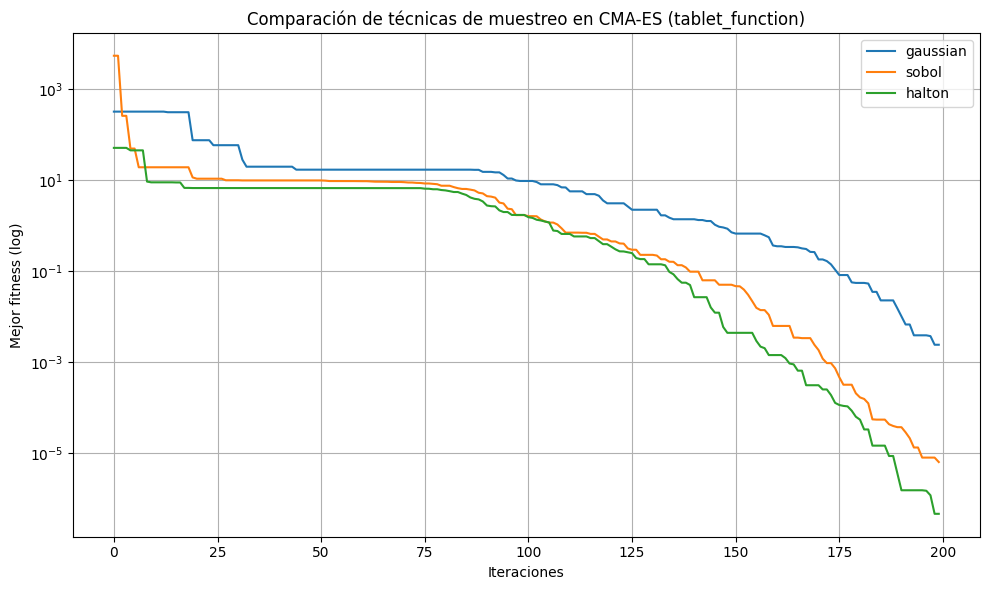

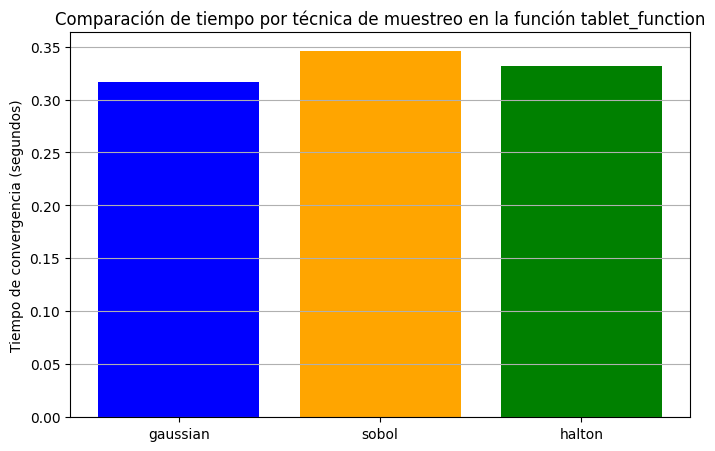

In [1]:
import numpy as np
import cma
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats.qmc import Sobol, Halton
import time

np.random.seed(42)
dim = 10
x0 = np.random.randn(dim)
sigma0 = 0.5
max_iter = 200


def tablet_function(x):
    return 1e6 * x[0]**2 + sum(xi**2 for xi in x[1:])

def schwefel_function(x):
    d = len(x)
    return 418.9829 * d - np.sum(x * np.sin(np.sqrt(np.abs(x))))

def michaelwicz_function(x, m=10):
    i = np.arange(1, len(x)+1)
    return -np.sum(np.sin(x) * (np.sin(i * x**2 / np.pi))**(2 * m))

def run_custom_cma(method=None, funcion=tablet_function, bounds = None):
    es = cma.CMAEvolutionStrategy(x0, sigma0, {
        'bounds': bounds,
        'maxiter': max_iter,
        'verb_disp': 0
    })

    # Inicialización del sampler si aplica
    if method == 'sobol':
        sampler = Sobol(d=dim, scramble=True)
    elif method == 'halton':
        sampler = Halton(d=dim, scramble=True)

    best_fitness = []

    while not es.stop():
        if method in ['sobol', 'halton']:
            # Genera vectores normales N(0,1) desde secuencia uniforme
            u_samples = sampler.random(n=es.popsize)
            z_samples = norm.ppf(u_samples)
        else:
            z_samples = np.random.randn(es.popsize, dim)

        # Usa z_samples como desviaciones estándar normales para reemplazar las generadas por es.ask()
        # Pero necesitamos seguir usando es.ask() para mantener el estado interno de CMA-ES
        ask_solutions = es.ask()
        B = es.sm.B
        D = es.sm.D
        C_matrix = B @ np.diag(D) @ B.T
        m = es.mean
        sigma = es.sigma

        # Forzamos que las soluciones usen nuestras muestras, preservando CMA lógica  
        if funcion == michaelwicz_function:
            solutions = [np.clip(m + sigma * C_matrix @ z, 0, np.pi) for z in z_samples]
        else:
            solutions = [np.clip(m + sigma * C_matrix @ z, bounds[0], bounds[1]) for z in z_samples]

        fitnesses = [funcion(x) for x in solutions]
        es.tell(solutions, fitnesses)
        best_fitness.append(es.result.fbest)

    return best_fitness, es.result.xbest, es.result.fbest

def ejecutar_cmaes(funcion, bounds):
    # Ejecuta todas las variantes
    results = {}
    times = {}
    for method in ['gaussian', 'sobol', 'halton']:
        print(f"Ejecutando CMA-ES con muestreo {method}...")
        start_time = time.time()
        fitness, xbest, fbest = run_custom_cma(method if method != 'gaussian' else None, funcion, bounds)
        elapsed_time = time.time() - start_time
        
        results[method] = (fitness, xbest, fbest)
        times[method] = elapsed_time
        

    # Visualización
    plt.figure(figsize=(10, 6))
    for method in results:
        plt.plot(results[method][0], label=method)
    plt.yscale('log')
    plt.xlabel('Iteraciones')
    plt.ylabel('Mejor fitness (log)')
    if funcion == michaelwicz_function:
        plt.yscale('linear')
    plt.title(f'Comparación de técnicas de muestreo en CMA-ES ({funcion.__name__})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Gráfica de comparación de tiempos
    methods = list(times.keys())
    durations = [times[m] for m in methods]

    plt.figure(figsize=(8, 5))
    plt.bar(methods, durations, color=['blue', 'orange', 'green'])
    plt.ylabel("Tiempo de convergencia (segundos)")
    plt.title("Comparación de tiempo por técnica de muestreo en la función " + funcion.__name__)
    plt.grid(axis='y')
    plt.show()
    
ejecutar_cmaes(tablet_function, [-5, 5])


5

6

7

Ejecutando CMA-ES con muestreo gaussian...
Ejecutando CMA-ES con muestreo sobol...
Ejecutando CMA-ES con muestreo halton...


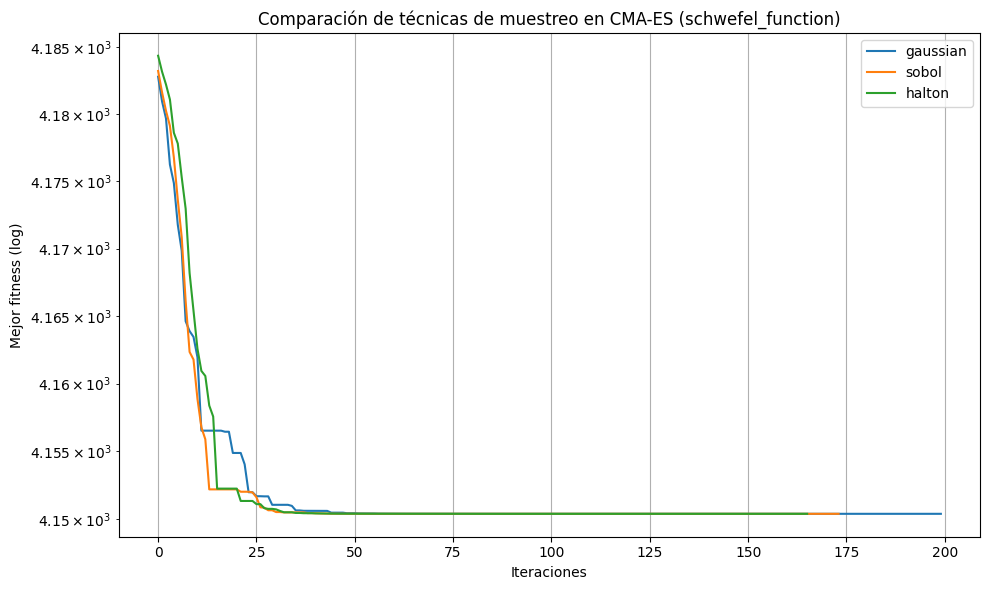

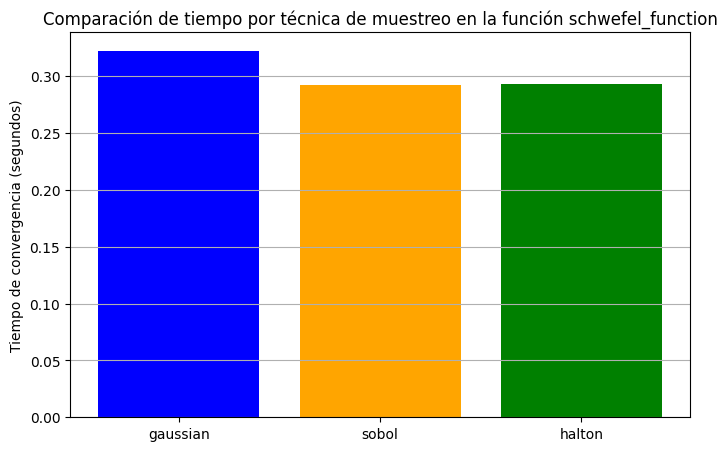

In [2]:
ejecutar_cmaes(schwefel_function, [-500, 500])

8


--- Ejecutando método: NORMAL ---
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=42, Mon Jun  9 12:58:59 2025)

--- Ejecutando método: SOBOL ---
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 10 (seed=42, Mon Jun  9 12:58:59 2025)

--- Ejecutando método: HALTON ---
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=42, Mon Jun  9 12:59:00 2025)


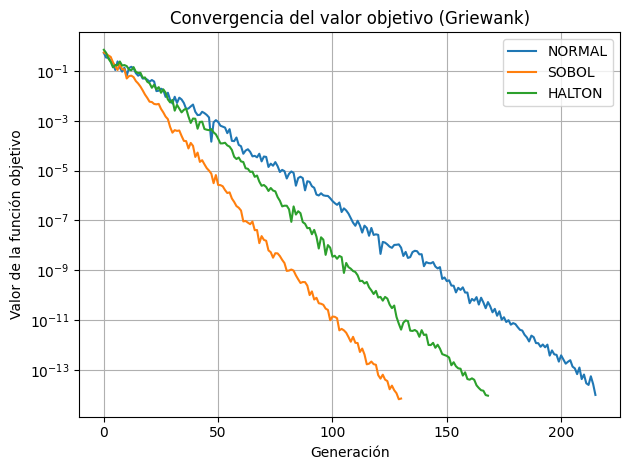

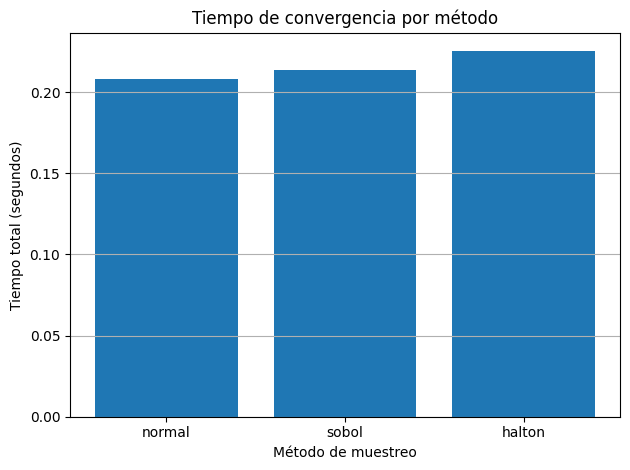

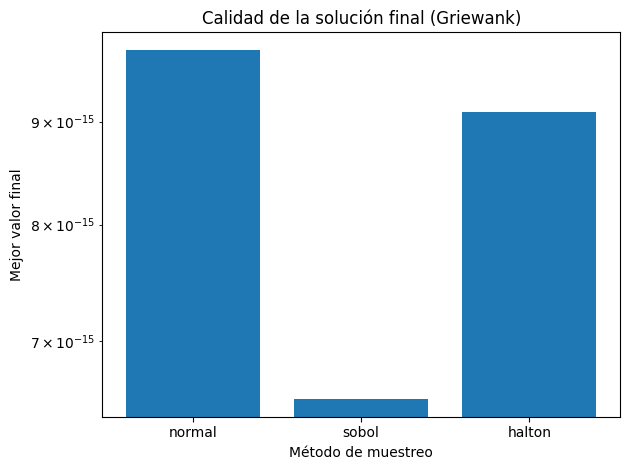

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc, norm
import cma
import time

# ----------------------
# Función objetivo: Griewank
# ----------------------
def griewank_function(x):
    x = np.array(x)
    sum_term = np.sum(x**2) / 4000
    prod_term = np.prod(np.cos(x / np.sqrt(np.arange(1, len(x)+1))))
    return 1 + sum_term - prod_term

# ----------------------
# Crear sampler Halton/Sobol
# ----------------------
def create_sampler(method, dim, seed):
    if method == "sobol":
        return qmc.Sobol(d=dim, scramble=True, seed=seed)
    elif method == "halton":
        return qmc.Halton(d=dim, scramble=True, seed=seed)
    else:
        raise ValueError("Método de muestreo no válido")

# Obtener muestras tipo normal a partir de Sobol/Halton
def get_normalized_samples(sampler, n_samples, dim):
    uniform_samples = sampler.random(n=n_samples)  # U(0,1)
    normal_samples = norm.ppf(uniform_samples)     # ~ N(0,1)
    return normal_samples

# ----------------------
# CMA-ES con muestreo normal
# ----------------------
def run_cma_es_normal(dim=10, sigma=0.5, seed=42, generations=300):
    x0 = np.random.default_rng(seed).normal(size=dim)
    es = cma.CMAEvolutionStrategy(x0.tolist(), sigma, {'seed': seed})
    fitness_history = []
    start_time = time.time()

    for _ in range(generations):
        solutions = es.ask()
        fitnesses = [griewank_function(x) for x in solutions]
        es.tell(solutions, fitnesses)
        fitness_history.append(np.min(fitnesses))
        if es.stop():
            break

    total_time = time.time() - start_time
    return fitness_history, total_time, griewank_function(es.result.xbest)

# ----------------------
# CMA-ES con muestreo Sobol/Halton convertido a normal
# ----------------------
def run_cma_es_custom(method, dim=10, sigma=0.5, seed=42, generations=300):
    x0 = np.random.default_rng(seed).normal(size=dim)

    popsize = 16 if method == "sobol" else None
    opts = {'seed': seed}
    if popsize:
        opts['popsize'] = popsize

    es = cma.CMAEvolutionStrategy(x0.tolist(), sigma, opts)
    sampler = create_sampler(method, dim, seed)

    fitness_history = []
    start_time = time.time()

    for _ in range(generations):
        solutions = es.ask()

        # Usamos norm.ppf() para transformar las muestras a normales
        base_samples = get_normalized_samples(sampler, len(solutions), dim)

        # Transformación estándar CMA-ES
        samples = [es.mean + es.sigma * es.B @ (es.D * s) for s in base_samples]

        fitnesses = [griewank_function(x) for x in samples]
        es.tell(samples, fitnesses)
        fitness_history.append(np.min(fitnesses))

        if es.stop():
            break

    total_time = time.time() - start_time
    return fitness_history, total_time, griewank_function(es.result.xbest)

# ----------------------
# Ejecución principal
# ----------------------
if __name__ == "__main__":
    dim = 10
    sigma = 0.5
    seed = 42
    generations = 300

    methods = ["normal", "sobol", "halton"]
    histories = {}
    times = {}
    final_values = {}

    for method in methods:
        print(f"\n--- Ejecutando método: {method.upper()} ---")
        if method == "normal":
            hist, t, final_val = run_cma_es_normal(dim, sigma, seed, generations)
        else:
            hist, t, final_val = run_cma_es_custom(method, dim, sigma, seed, generations)
        histories[method] = hist
        times[method] = t
        final_values[method] = final_val

    # ----------------------
    # Gráfica de convergencia
    # ----------------------
    plt.figure()
    for method in methods:
        plt.plot(histories[method], label=method.upper())
    plt.yscale('log')
    plt.xlabel('Generación')
    plt.ylabel('Valor de la función objetivo')
    plt.title('Convergencia del valor objetivo (Griewank)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ----------------------
    # Gráfica de tiempos
    # ----------------------
    plt.figure()
    plt.bar(methods, [times[m] for m in methods])
    plt.xlabel('Método de muestreo')
    plt.ylabel('Tiempo total (segundos)')
    plt.title('Tiempo de convergencia por método')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # ----------------------
    # Gráfica de calidad final
    # ----------------------
    plt.figure()
    plt.bar(methods, [final_values[m] for m in methods])
    plt.xlabel('Método de muestreo')
    plt.ylabel('Mejor valor final')
    plt.yscale('log')
    plt.title('Calidad de la solución final (Griewank)')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


9

10

11


--- Ejecutando método: NORMAL ---
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=42, Mon Jun  9 13:00:33 2025)

--- Ejecutando método: SOBOL ---
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 2 (seed=42, Mon Jun  9 13:00:33 2025)

--- Ejecutando método: HALTON ---
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=42, Mon Jun  9 13:00:33 2025)


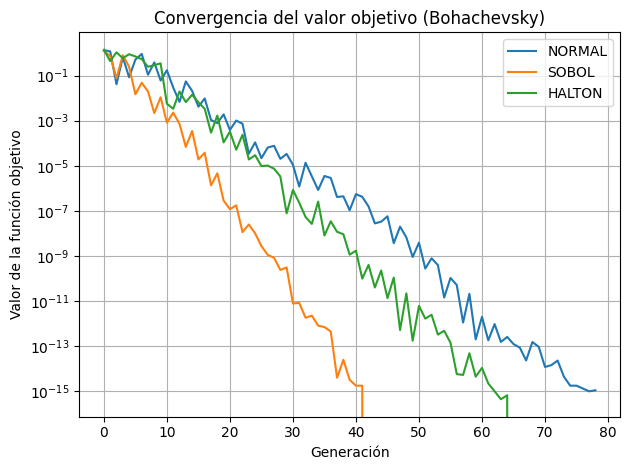

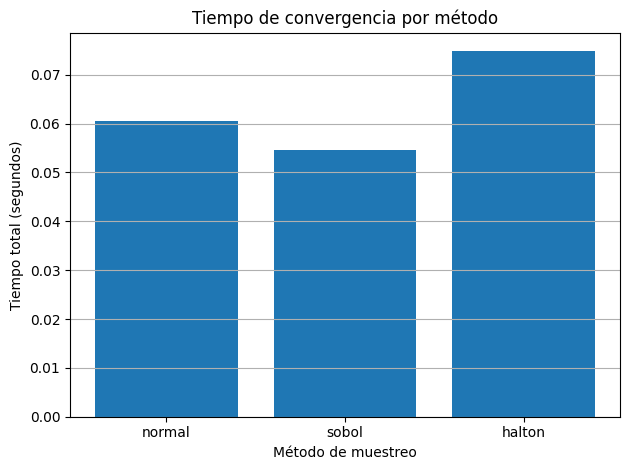

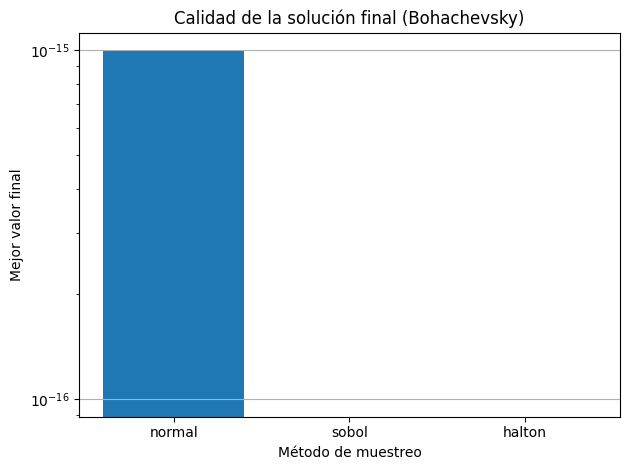

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc, norm
import cma
import time

# ----------------------
# Función objetivo: Bohachevsky #1
# ----------------------
def bohachevsky_function(x):
    x = np.array(x)
    return x[0]**2 + 2 * x[1]**2 - 0.3 * np.cos(3 * np.pi * x[0]) - 0.4 * np.cos(4 * np.pi * x[1]) + 0.7

# ----------------------
# Crear sampler Halton/Sobol
# ----------------------
def create_sampler(method, dim, seed):
    if method == "sobol":
        return qmc.Sobol(d=dim, scramble=True, seed=seed)
    elif method == "halton":
        return qmc.Halton(d=dim, scramble=True, seed=seed)
    else:
        raise ValueError("Método de muestreo no válido")

# Obtener muestras tipo normal a partir de Sobol/Halton
def get_normalized_samples(sampler, n_samples, dim):
    uniform_samples = sampler.random(n=n_samples)  # U(0,1)
    normal_samples = norm.ppf(uniform_samples)     # ~ N(0,1)
    return normal_samples

# ----------------------
# CMA-ES con muestreo normal
# ----------------------
def run_cma_es_normal(dim=2, sigma=0.5, seed=42, generations=300):
    x0 = np.random.default_rng(seed).normal(size=dim)
    es = cma.CMAEvolutionStrategy(x0.tolist(), sigma, {'seed': seed})
    fitness_history = []
    start_time = time.time()

    for _ in range(generations):
        solutions = es.ask()
        fitnesses = [bohachevsky_function(x) for x in solutions]
        es.tell(solutions, fitnesses)
        fitness_history.append(np.min(fitnesses))
        if es.stop():
            break

    total_time = time.time() - start_time
    return fitness_history, total_time, bohachevsky_function(es.result.xbest)

# ----------------------
# CMA-ES con muestreo Sobol/Halton convertido a normal
# ----------------------
def run_cma_es_custom(method, dim=2, sigma=0.5, seed=42, generations=300):
    x0 = np.random.default_rng(seed).normal(size=dim)

    popsize = 16 if method == "sobol" else None
    opts = {'seed': seed}
    if popsize:
        opts['popsize'] = popsize

    es = cma.CMAEvolutionStrategy(x0.tolist(), sigma, opts)
    sampler = create_sampler(method, dim, seed)

    fitness_history = []
    start_time = time.time()

    for _ in range(generations):
        solutions = es.ask()
        base_samples = get_normalized_samples(sampler, len(solutions), dim)
        samples = [es.mean + es.sigma * es.B @ (es.D * s) for s in base_samples]

        fitnesses = [bohachevsky_function(x) for x in samples]
        es.tell(samples, fitnesses)
        fitness_history.append(np.min(fitnesses))

        if es.stop():
            break

    total_time = time.time() - start_time
    return fitness_history, total_time, bohachevsky_function(es.result.xbest)

# ----------------------
# Ejecución principal
# ----------------------
if __name__ == "__main__":
    dim = 2
    sigma = 0.5
    seed = 42
    generations = 300

    methods = ["normal", "sobol", "halton"]
    histories = {}
    times = {}
    final_values = {}

    for method in methods:
        print(f"\n--- Ejecutando método: {method.upper()} ---")
        if method == "normal":
            hist, t, final_val = run_cma_es_normal(dim, sigma, seed, generations)
        else:
            hist, t, final_val = run_cma_es_custom(method, dim, sigma, seed, generations)
        histories[method] = hist
        times[method] = t
        final_values[method] = final_val

    # ----------------------
    # Gráfica de convergencia
    # ----------------------
    plt.figure()
    for method in methods:
        plt.plot(histories[method], label=method.upper())
    plt.yscale('log')
    plt.xlabel('Generación')
    plt.ylabel('Valor de la función objetivo')
    plt.title('Convergencia del valor objetivo (Bohachevsky)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ----------------------
    # Gráfica de tiempos
    # ----------------------
    plt.figure()
    plt.bar(methods, [times[m] for m in methods])
    plt.xlabel('Método de muestreo')
    plt.ylabel('Tiempo total (segundos)')
    plt.title('Tiempo de convergencia por método')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # ----------------------
    # Gráfica de calidad final
    # ----------------------
    plt.figure()
    plt.bar(methods, [final_values[m] for m in methods])
    plt.xlabel('Método de muestreo')
    plt.ylabel('Mejor valor final')
    plt.yscale('log')
    plt.title('Calidad de la solución final (Bohachevsky)')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

12

Ejecutando CMA-ES con muestreo gaussian...
Ejecutando CMA-ES con muestreo sobol...
Ejecutando CMA-ES con muestreo halton...


C:\Users\santi\AppData\Local\Temp\ipykernel_14208\1844098556.py:88: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


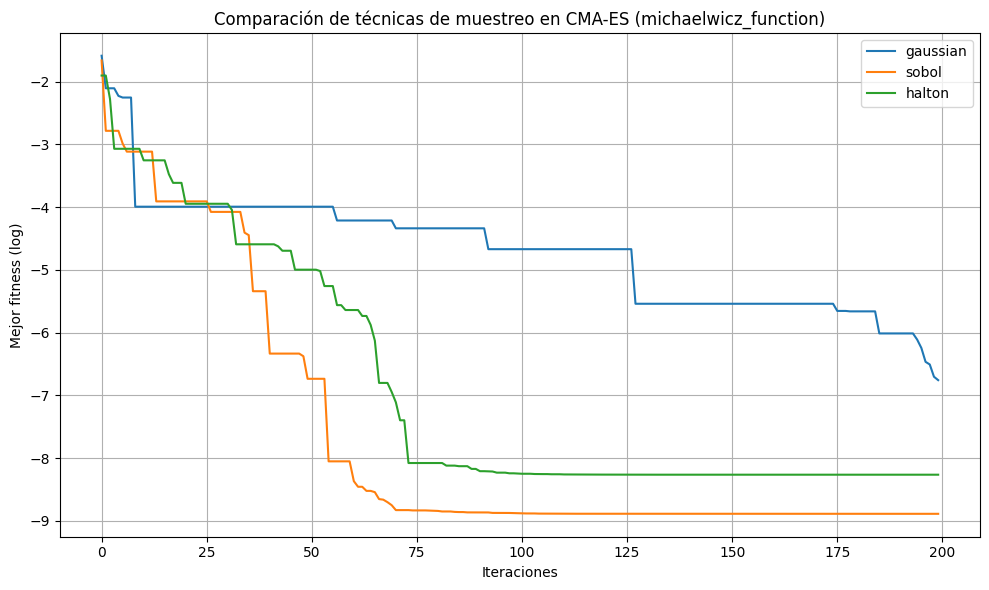

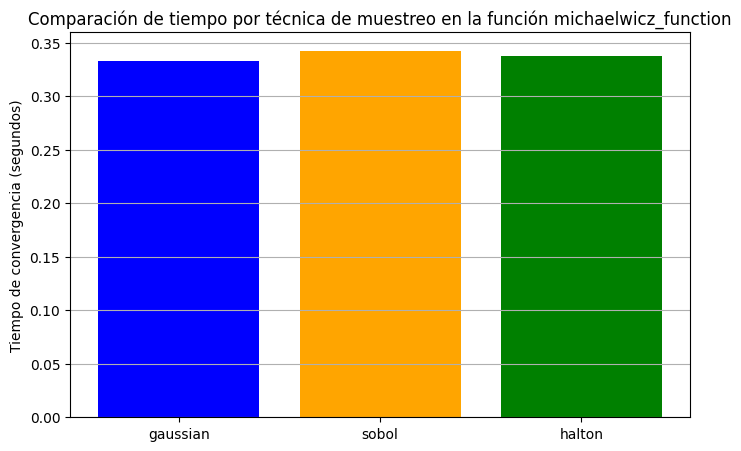

In [3]:
ejecutar_cmaes(michaelwicz_function, [-5, 5])